# Notebook demonstrating the use of Timeseriesai for generating predictions
https://github.com/timeseriesAI/timeseriesAI

## The below is done using the tutorial data set (one state, one season) and is a very small dataset so the results are only intended for use on how to use this, not necessarily what the ML capability is

### uses env timeseriesai

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tsai.all import *
from joblib import Parallel, delayed
from openavalancheproject.tsai_utilities import *


In [3]:
import mlflow
from azureml.core import Workspace

In [4]:
ws = Workspace.from_config()
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

In [3]:
data_root = '/media/scottcha/Data2/OAPMLData/'

ml_path = data_root + '/5.MLData/'
num_features = 771
interpolation = 1
label = 'Day1DangerAboveTreeline'
file_label = 'co_day1above_nooversample_med'
#file_label = 'day1above'
#label = 'Day1DangerAboveTreeline'

In [136]:
mlflow.set_experiment(file_label)

NameError: name 'mlflow' is not defined

In [9]:
mlflow.log_param('TrainSamples', 5000)

In [4]:
#load the full X datafile which has both Train and Test concated
X = np.load(ml_path + '/X_all_' + file_label + '.npy', mmap_mode='r')

In [5]:
X.shape

(12000, 771, 180)

In [6]:
utils = TSAIUtilities(X, label)

In [7]:
X = X[:,:,:]

In [294]:
mlflow.log_param('Lookback', 30)

NameError: name 'mlflow' is not defined

In [8]:
#read in the corresponding label files and concat them
#can get the right values here based on the contents of hte ml_path directory

num_train_files = 2
file_list = []
for i in range(num_train_files):
    file_list.append(pd.read_parquet(ml_path + '/y_train_batch_' + str(i) + '_' + file_label + '.parquet'))

    
num_test_files = 1
for i in range(num_test_files):
    file_list.append(pd.read_parquet(ml_path + '/y_test_batch_' + str(i) + '_' + file_label + '.parquet'))
    
y_df = pd.concat(file_list).reset_index(drop=True)

In [9]:
y_df['Day1DangerAboveTreeline'].value_counts()

Considerable    3017
Low             3017
Moderate        3016
High            2950
Name: Day1DangerAboveTreeline, dtype: int64

In [10]:
y_df.shape[0]

12000

In [11]:
X = X[:y_df.shape[0], :, :]

In [12]:
X.shape

(12000, 771, 180)

In [13]:
y_df.shape

(12000, 302)

In [14]:
no_dupes = y_df.drop_duplicates()

In [15]:
no_dupes.shape

(12000, 302)

In [16]:
y_df['season'].value_counts()

18-19    2758
17-18    2166
20-21    2000
15-16    1797
16-17    1693
19-20    1586
Name: season, dtype: int64

In [17]:
y_df['parsed_date'].value_counts()

2017-01-10    111
2019-03-07    110
2019-03-13    103
2019-03-09     96
2020-12-29     96
             ... 
2015-11-19      1
2017-01-29      1
2017-02-03      1
2016-11-20      1
2020-12-17      1
Name: parsed_date, Length: 933, dtype: int64

In [18]:
y_df[label].value_counts()

Considerable    3017
Low             3017
Moderate        3016
High            2950
Name: Day1DangerAboveTreeline, dtype: int64

In [19]:
y, cat_dict = utils.get_y_as_cat(y_df)
cat_dict

{0: 'Low', 1: 'Moderate', 2: 'Considerable', 3: 'High'}

In [20]:
#index file which indicates which rows in X are train or test
#be carful these don't overlap
num_test = 2000
train_test_split = y.shape[0]-num_test

#can use a smaller train subset to make development faster
splits_2 = (L([i for i in range(0,train_test_split)]).shuffle(), L([i for i in range(train_test_split,train_test_split+num_test)]).shuffle())

In [21]:
splits_2

((#10000) [9407,936,7013,5008,422,2914,8408,7386,6902,2510...],
 (#2000) [11266,10084,10585,11609,10805,10601,11844,10546,11255,10302...])

In [122]:
X.shape

(25000, 771, 180)

In [22]:
#create the dataset
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits_2, inplace=True)

<AxesSubplot:title={'center':'0'}>

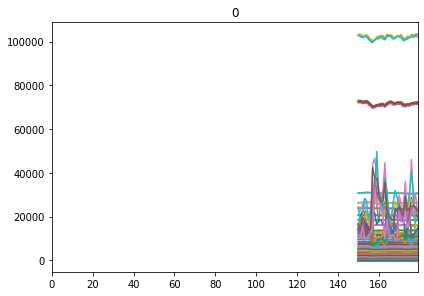

In [23]:
#check on set
show_at(dsets.valid, 1)

In [24]:
#create the dataloader
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64], batch_tfms=[TSStandardize(by_var=True), Nan2Value()], num_workers=0)

In [25]:
#check both the train and test sets to ensure that there aren't full rows with all nulls

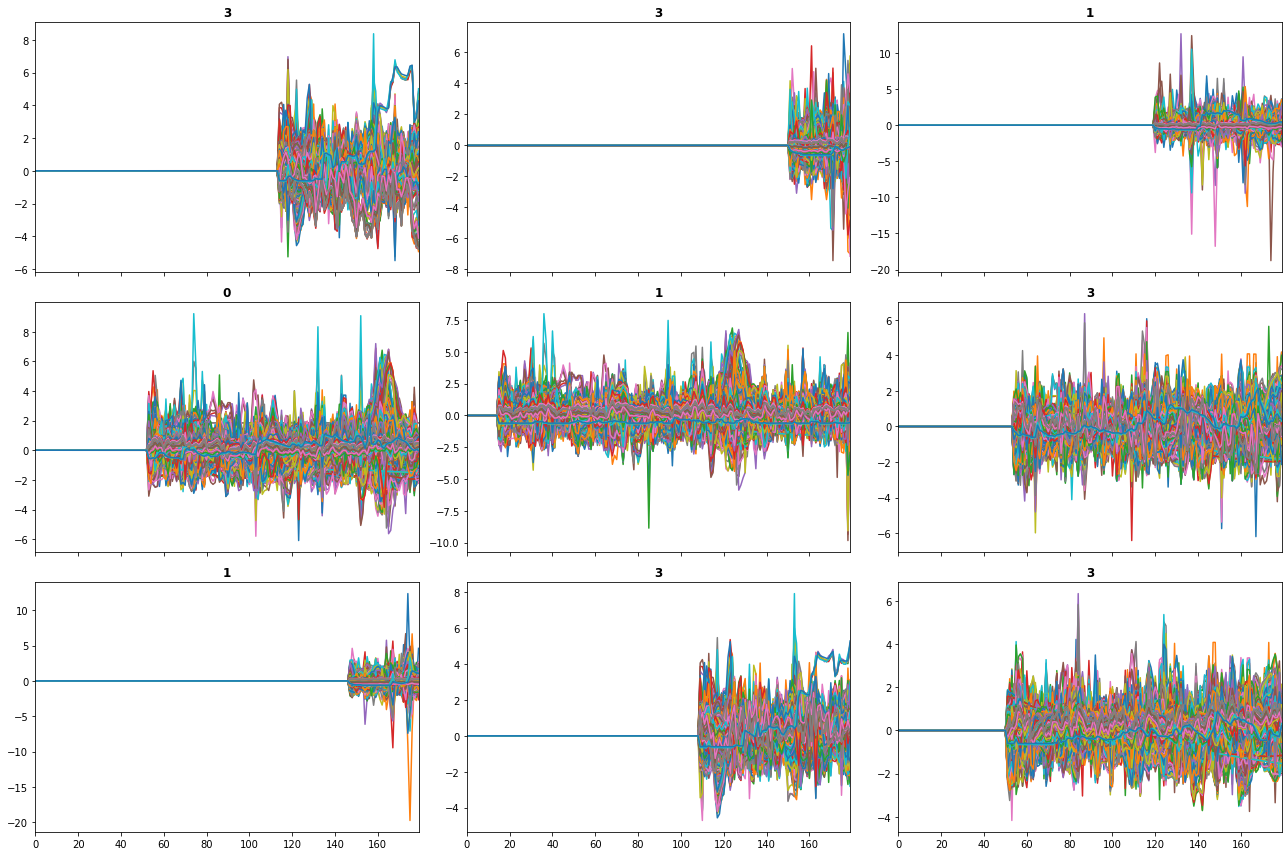

In [26]:
dls.show_batch()

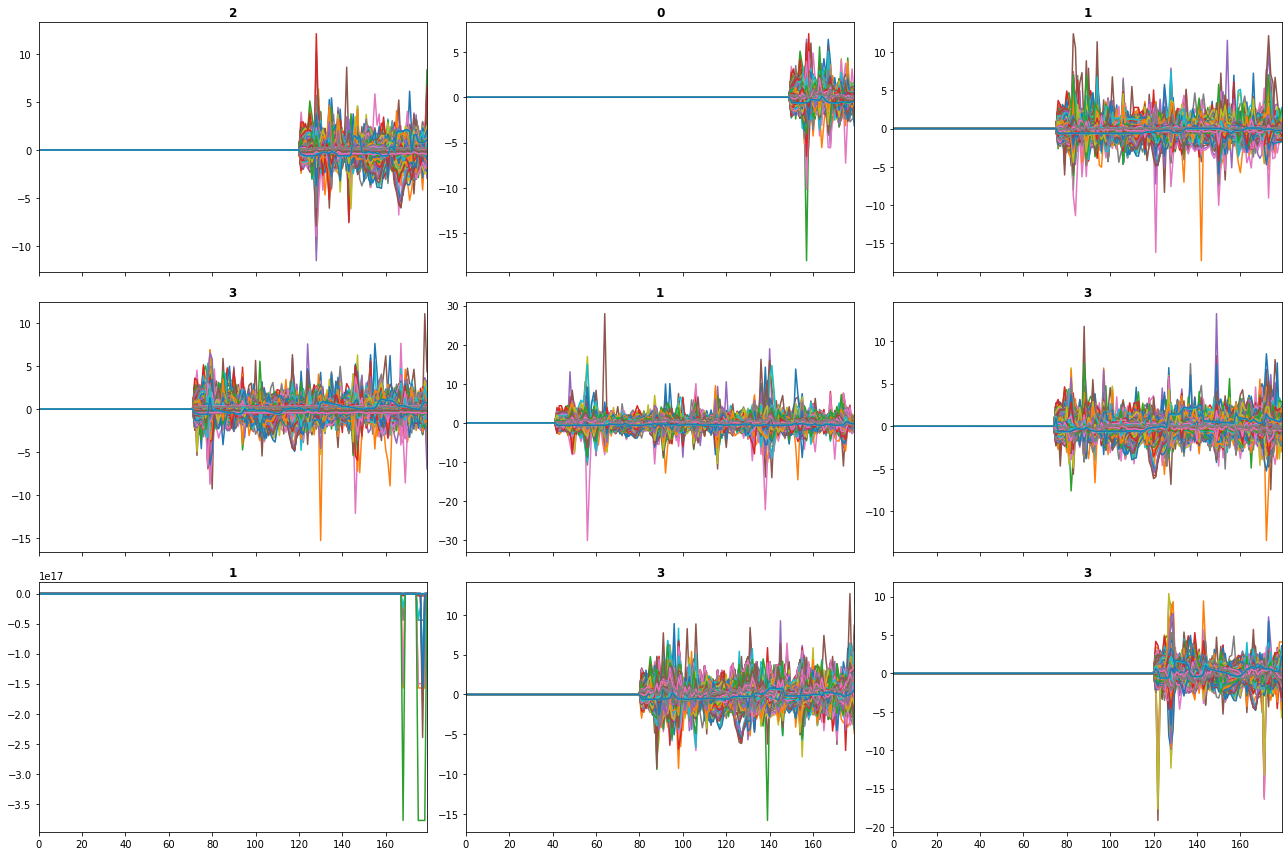

In [27]:
dls.valid.show_batch()

In [28]:
dls.c

4

In [29]:
dls.vars

771

# Lets try and train a model, in the tutorial case we are using an extremely small dataset so no conclusions should be drawn from these results they are for illustrative purposes only

In [56]:
batch_tfms = [TSStandardize(by_var=True), Nan2Value()]
learn = TSClassifier(X, y, splits=splits_2, arch=InceptionTimePlus, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph(), verbose=True)

arch: InceptionTimePlus(c_in=771 c_out=4 seq_len=180 device=cuda:0, kwargs={})


/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)
/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


epoch,train_loss,valid_loss,accuracy,time
0,1.086480,39711414419456.000000,0.560000,00:03
1,0.829436,971993109233664.000000,0.371000,00:02
2,0.697309,312628454883328.000000,0.360000,00:02
3,0.647067,653547121147904.000000,0.404000,00:02
4,0.588173,138870452649984.000000,0.518000,00:02
5,0.518326,307216963862528.000000,0.413000,00:02
6,0.491560,410702288257024.000000,0.423000,00:02
7,0.440483,458235999944704.000000,0.397000,00:02
8,0.389640,691355047165952.000000,0.443000,00:02
9,0.368704,935012098637824.000000,0.396000,00:02


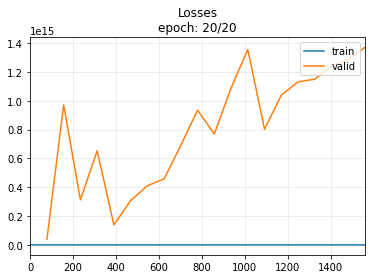

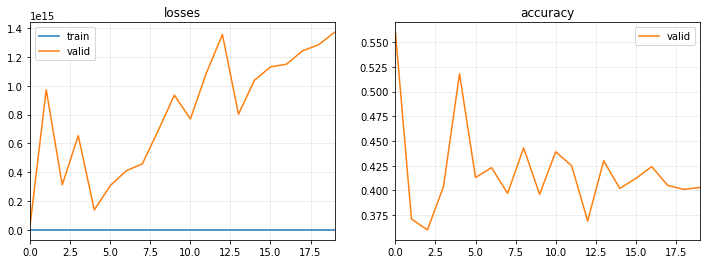

In [57]:
learn.fit_one_cycle(20, 1e-2)

In [109]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)

In [30]:
model = LSTM(dls.vars, 
                    dls.c,
                    hidden_size=200, 
                    n_layers=5, 
                    rnn_dropout=.8,
                    bidirectional=False,
                    fc_dropout=.8)
learn = Learner(dls, model, metrics=accuracy)



/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0020892962347716093)

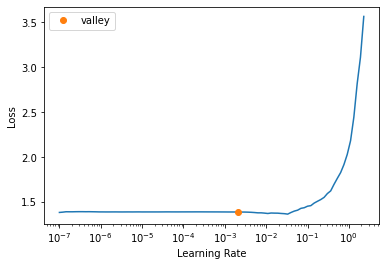

In [132]:
learn.lr_find()

In [37]:
mlflow.log_param('lr', 1e-02)

NameError: name 'mlflow' is not defined

In [31]:
#without oversampling
learn.fit_one_cycle(40, lr_max=1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.121074,1.175561,0.393000,00:20
1,0.880084,1.324080,0.439500,00:20
2,0.815738,1.034149,0.504500,00:20
3,0.826832,1.221942,0.437000,00:20
4,0.875093,1.529569,0.433500,00:20
5,0.925291,1.313022,0.512000,00:20
6,0.977943,1.057818,0.548500,00:20
7,1.046168,1.115040,0.485000,00:20
8,1.105881,1.058405,0.480000,00:20
9,1.141876,1.032392,0.513000,00:20


In [94]:
#without oversampling
learn.fit_one_cycle(10, lr_max=1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.065120,1.358157,0.429000,00:20
1,1.025032,1.065700,0.486000,00:20
2,1.123859,1.217319,0.435000,00:20
3,1.150161,1.014488,0.512000,00:20
4,1.141155,1.075460,0.501000,00:20
5,1.119637,1.075879,0.543000,00:20
6,1.075567,1.000955,0.578500,00:20
7,1.037425,0.959763,0.599000,00:20
8,1.014620,0.970048,0.589000,00:21
9,1.023133,0.968723,0.590000,00:20


In [47]:
mlflow.log_param('Model', str(type(model)))

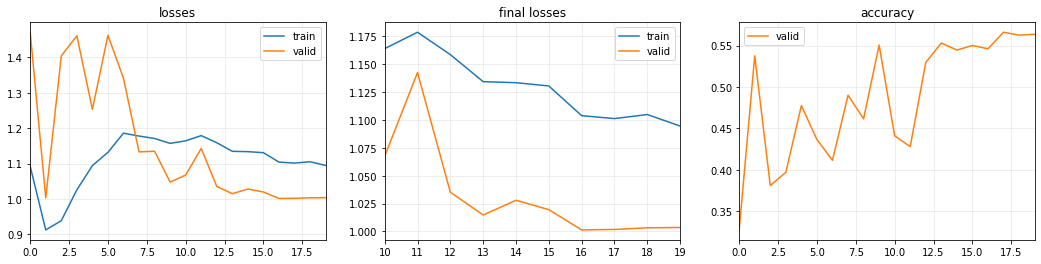

In [165]:
learn.recorder.plot_metrics()

### Results


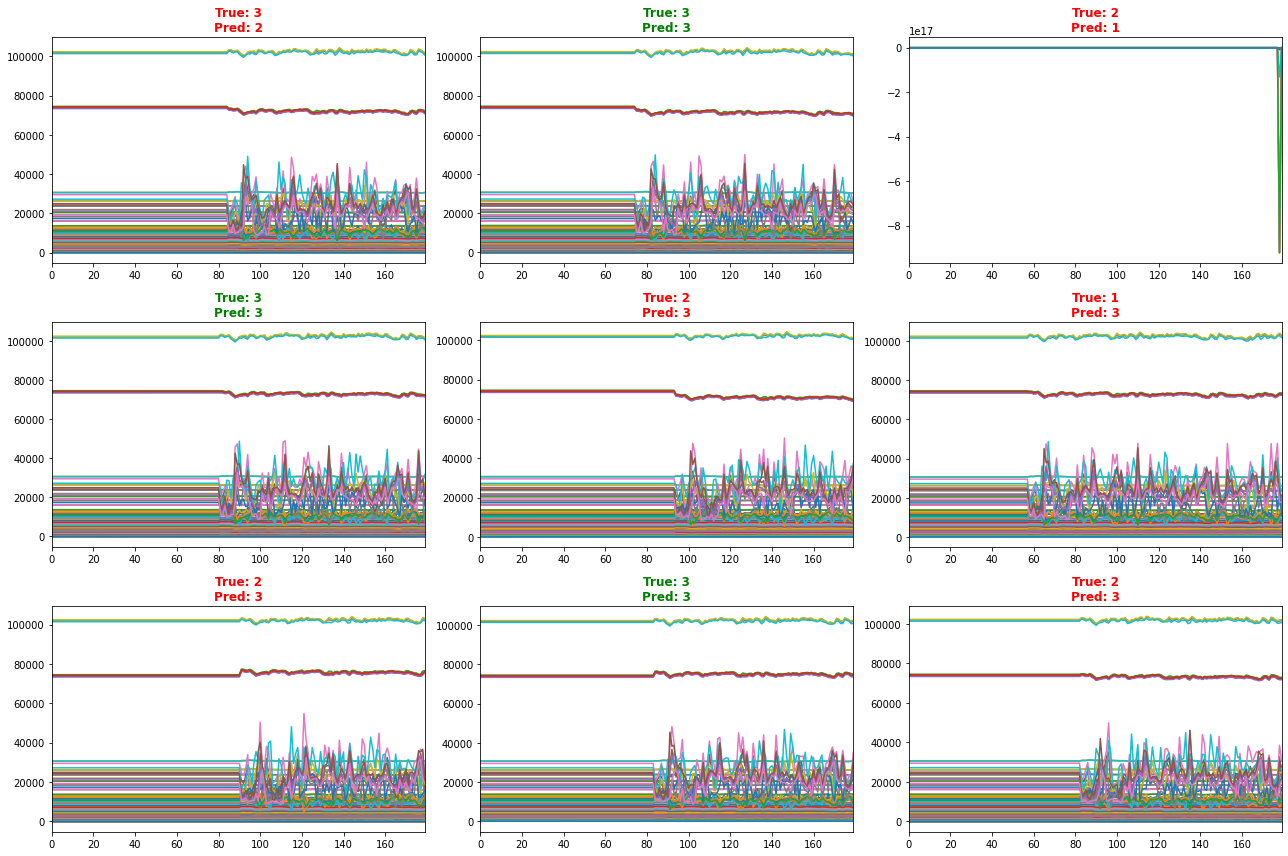

In [32]:
learn.show_results()

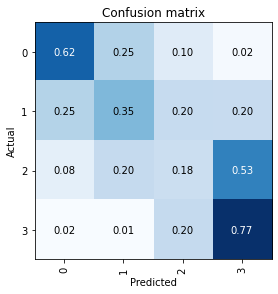

In [33]:
#d,t = flatten_check(interp.decoded, interp.targs)
#print(str(skm.accuracy_score(t, d)))
interp = ClassificationInterpretation.from_learner(learn)
conf_matrix = interp.plot_confusion_matrix(normalize=True)

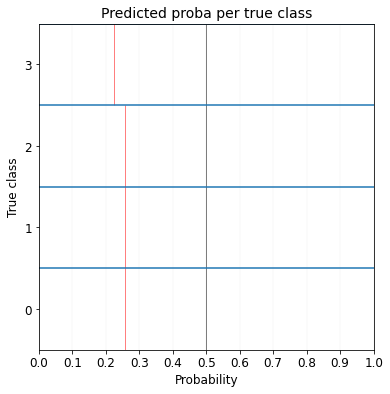

In [34]:
learn.show_probas()

In [35]:
interp.most_confused(min_val=3)

[(2, 3, 275),
 (0, 1, 128),
 (1, 0, 127),
 (2, 1, 105),
 (1, 2, 104),
 (1, 3, 102),
 (3, 2, 91),
 (0, 2, 54),
 (2, 0, 43),
 (0, 3, 12),
 (3, 0, 7),
 (3, 1, 6)]

In [173]:
mlflow.log_param('Model', str(type(m)))
mlflow.log_param('Num Hidden ', h)
mlflow.log_param('Num Layers ', l)
mlflow.log_param('RNN Dropout ',d)
mlflow.log_param('FC Dropout ', f)
mlflow.log_param('Bidirectional ',b)

In [244]:
cm = interp.confusion_matrix()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for r in range(len(cm)):
    for c in range(len(cm[r])):
        mlflow.log_metric('Actual ' + str(r) + ' Predicted ' + str(c), cm[r,c])

d,t = flatten_check(interp.decoded, interp.targs)
mlflow.log_metric('Test Accuracy', skm.accuracy_score(t, d))

NameError: name 'mlflow' is not defined

In [175]:
mlflow.end_run()

In [246]:
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

/home/scottcha/miniconda3/envs/tsai2.22/lib/python3.8/site-packages/mpl_toolkits/axes_grid1/__init__.py:2: MatplotlibDeprecationWarning: 
The deprecated function was deprecated in Matplotlib 3.4 and will be removed two minor releases later.
  from .axes_divider import Divider, SubplotDivider, LocatableAxes, \


In [331]:
net = learn.model.cpu()

In [332]:
b = dls.one_batch()

In [333]:
test_input_tensor = b[0].type(torch.FloatTensor)

In [334]:
test_labels = b[1].cpu().data.numpy()

In [335]:
out_probs = net(test_input_tensor).detach().cpu().numpy()
out_classes = np.argmax(out_probs, axis=1)
train_accuracy = sum(out_classes == test_labels) / len(test_labels)
print("Accuracy:", train_accuracy )

Accuracy: 0.734375


In [43]:
mlflow.log_metric('Train Accuracy', train_accuracy)

NameError: name 'mlflow' is not defined

In [336]:
ig = IntegratedGradients(net)

In [337]:
#test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

In [338]:
feature_names = pd.read_csv(ml_path + '/FeatureLabels_' + file_label + '.csv')
feature_names = feature_names['0'].sort_values().values

In [288]:
feature_names = feature_names[feature_filter]

NameError: name 'feature_filter' is not defined

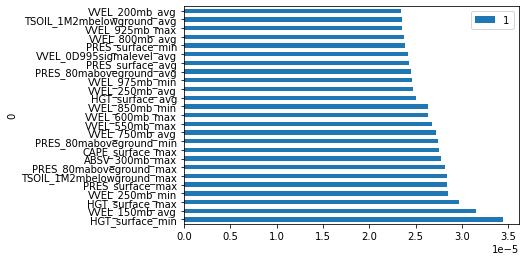

In [339]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    pd.DataFrame(zip(feature_names, np.mean(importances, axis=(0,2)))).sort_values(1, ascending=False)[:25].plot.barh(x=0, y=1)

visualize_importances(feature_names, attr)

In [50]:
top_features =  pd.DataFrame(zip(feature_names, np.mean(attr, axis=(0,2))), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

In [51]:
top_features.to_csv('../Scratch/Notebooks/' + '/FeatureImportances.csv')

In [29]:
top_features = pd.read_csv('../Scratch/Notebooks/' + '/FeatureImportances.csv')

In [85]:
orig_X = X

In [86]:
orig_feature_means = feature_means

In [87]:
orig_feature_std = feature_std

In [134]:
mlflow.end_run()

In [88]:
feature_filter = top_features[:100].index

In [89]:
X = orig_X[:, feature_filter, :]
feature_means = orig_feature_means[feature_filter]
feature_std = orig_feature_std[feature_filter]

In [35]:
fill_values = torch.zeros_like(TSTensor(X))
for i in range(0,X.shape[1]):
    fill_values[:,i,:] = torch.full_like(TSTensor(X[:,i,:]), feature_means[i])
        
X_noNan = torch.where(torch.isnan(TSTensor(X)), fill_values, TSTensor(X))

In [40]:
X_noNan[:,:,-30:].shape

torch.Size([6000, 100, 30])